In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part 1. Read data from csv file and preprocessing

Read the CSV file and observe the structure of the data. Since it only gives the timestamp and the speed of the corresponding time, so we need to do EDA(exploratory data analysis) and see which time data has a significant effect on the speed.

In [2]:
trafficFile = 'train.csv'
traffic = pd.read_csv(trafficFile, index_col="id", parse_dates=[1], dayfirst=True)
# traffic = traffic.drop(columns='id')
traffic.head()

,date,speed
id,,
0,2017-01-01 00:00:00,43.002930
1,2017-01-01 01:00:00,46.118696
2,2017-01-01 02:00:00,44.294158
3,2017-01-01 03:00:00,41.067468
4,2017-01-01 04:00:00,46.448653


Based on EDA, we can discover that there is a big difference in the distribution of traffic speed between weekdays and weekends. Meanwhile, through the average velocity distribution, we can see that the velocity of identical months and each day within each month has a large fluctuation. So it's admirable to take month, date, day of week, and hour as the feature of the model, and also include the given timestamp as an analysis feature after normalization

In [3]:
traffic['hour'] = pd.to_datetime(traffic['date']).apply(lambda x: x.hour)
traffic['hour'] = traffic['hour']/23
traffic['weekday'] = pd.to_datetime(traffic['date']).apply(lambda x: x.dayofweek)
traffic['weekday'] = traffic['weekday']/6
traffic['month']=pd.to_datetime(traffic['date']).apply(lambda x:x.month)
traffic['month']=traffic['month']/12
traffic['day']=pd.to_datetime(traffic['date']).apply(lambda x:x.day)
traffic['day']=traffic['day']/30
max_time = max(traffic['date'])
min_time = min(traffic['date'])
traffic['time'] = (traffic['date']-min_time)/(max_time-min_time)

Set parameters for the dataset and split the original dataset into a training dataset and a testing one.

In [4]:
from sklearn.model_selection import train_test_split
X = traffic[['time','weekday','hour','month','day']]
y = traffic['speed']

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.05,random_state=0)

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn import metrics

## Part2. Regression and Plot the result

In [11]:
def regression_method(model):
    model.fit(x_train,y_train)
    score = model.score(x_test, y_test)
    result = model.predict(x_test)
    ResidualSquare = (result - y_test)**2
    RSS = sum(ResidualSquare)
    MSE = np.mean(ResidualSquare)
    num_regress = len(result)
    print(f'n={num_regress}')
    print(f'R^2={score}')
    print(f'MSE={MSE}')
    print(f'RSS={RSS}')
    # Verify the out of bag error and in bag error to prevent overfitting
    print('Out of Bag:',model.oob_score_)
    # Draw line chart to show the difference between the predicting value and actual value
    plt.figure(figsize=(20,8),dpi=80)
    # Verify with scatter plot, points that are closer to the 1:1 line means that the corresponding predicting value is closer to its actual value
    plt.plot(np.arange(len(result)), y_test,'go-',label='true value')
    plt.plot(np.arange(len(result)),result,'ro-',label='predict value')
    plt.title('RandomForestRegression R^2: %f'%score)
    plt.legend()
    plt.show()
    return result,model

In [12]:
# Verify with scatter plot, points that are closer to the 1:1 line means that the corresponding predicting value is closer to its actual value
def scatter_plot(TureValues,PredictValues):
    # set the referenced 1:1 line
    xxx = [10,50]
    yyy = [10,50]
    plt.figure()
    plt.plot(xxx , yyy , c='0' , linewidth=1 , linestyle=':' , marker='.' , alpha=0.3)
    # scatter plot, whose x represents actural value and y represents predicting value
    plt.scatter(TureValues , PredictValues , s=20 , c='r' , edgecolors='k' , marker='o' , alpha=0.8)
    plt.xlim((10,50))
    plt.ylim((10,50))
    plt.title('RandomForestRegressionScatterPlot')
    plt.show()

In [13]:
from sklearn.ensemble import RandomForestRegressor

In [14]:
# set the model
model_RandomForestRegressor = RandomForestRegressor(n_estimators=800,oob_score=True,random_state=50)

n=701
R^2=0.9264724433716381
MSE=13.49074701340287
RSS=9457.013656395413
Out of Bag: 0.9274397125610158


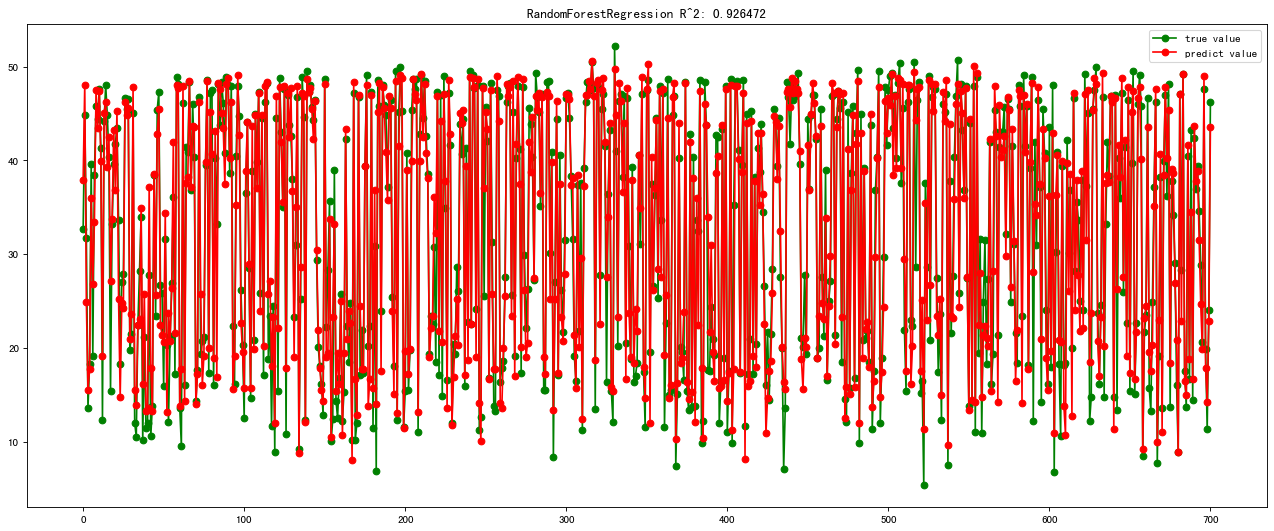

In [15]:
# get the predicting result, accuracy, and plot that represents difference between predicted value and actual value
y_pred,trained_model = regression_method(model_RandomForestRegressor)

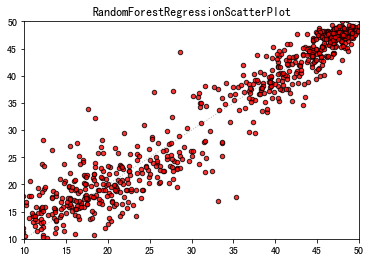

In [16]:
scatter_plot(y_test,y_pred)

## Part3. Adjust the parameters of the model and reach an admirable result

Due to the limitation of computer performance, we only adjust parameters one by one or set some related parameters as a group to adjust

### (1) n_estimator

In [17]:
param_test1 = {'n_estimators':range(1450,1551,10)}
rf = RandomForestRegressor(oob_score=True, random_state=50, n_jobs=6)
gsearch1 = GridSearchCV(estimator = rf, param_grid = param_test1,cv=5)
gsearch1.fit(x_train,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([9.11163368, 8.98260827, 9.08404837, 9.4805963 , 9.60082612,
         9.27478123, 9.52514   , 9.32182822, 9.56965146, 9.43717709,
         9.49010439]),
  'std_fit_time': array([0.10912619, 0.10964117, 0.02456418, 0.28010908, 0.1601012 ,
         0.08875522, 0.08471495, 0.06975409, 0.0721925 , 0.11725906,
         0.06946788]),
  'mean_score_time': array([0.25875049, 0.24382591, 0.25401859, 0.25469732, 0.26186371,
         0.26085219, 0.2629488 , 0.25290365, 0.25252795, 0.26347399,
         0.25659771]),
  'std_score_time': array([0.00690361, 0.00421727, 0.00660629, 0.01305944, 0.01379256,
         0.00838871, 0.02520073, 0.00285416, 0.00323004, 0.01282274,
         0.00506599]),
  'param_n_estimators': masked_array(data=[1450, 1460, 1470, 1480, 1490, 1500, 1510, 1520, 1530,
                     1540, 1550],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False],
         fill_value='?',
          

### (2) max_features

In [18]:
param_test2 = {'max_features':range(2,6,1)}
rf = RandomForestRegressor(n_estimators=1510, oob_score=True, random_state=50, n_jobs=6)
gsearch2 = GridSearchCV(estimator = rf,param_grid = param_test2,cv=5)
gsearch2.fit(x_train,y_train)                                                                                                                                                                                                                                  
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([7.38123403, 8.06986375, 8.69279485, 9.62802873]),
  'std_fit_time': array([0.09482865, 0.07284534, 0.07990207, 0.12139728]),
  'mean_score_time': array([0.25984235, 0.2669548 , 0.26111107, 0.27673812]),
  'std_score_time': array([0.00267287, 0.00385343, 0.00737552, 0.01293978]),
  'param_max_features': masked_array(data=[2, 3, 4, 5],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_features': 2},
   {'max_features': 3},
   {'max_features': 4},
   {'max_features': 5}],
  'split0_test_score': array([0.93111892, 0.92822184, 0.92423634, 0.92107242]),
  'split1_test_score': array([0.93490531, 0.93300763, 0.93014923, 0.92849761]),
  'split2_test_score': array([0.93152355, 0.92944811, 0.92631689, 0.92405998]),
  'split3_test_score': array([0.93628364, 0.93488462, 0.93206751, 0.93006111]),
  'split4_test_score': array([0.93064086, 0.92825053, 0.92509505, 0.92284962]),
  'mean_test_score': array(

### (3) max_depth and min_samples_split

In [20]:
param_test3 = {'max_depth': list(range(18, 31, 2)), 'min_samples_split': list(range(2, 8, 1))}
rf = RandomForestRegressor(max_features=2, n_estimators=1510, oob_score=True, random_state=50, n_jobs=6)
gsearch3 = GridSearchCV(estimator = rf,param_grid = param_test3, cv=5)
gsearch3.fit(x_train,y_train)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([6.61315732, 5.73352175, 5.24497271, 5.02308359, 4.89853768,
         4.73152552, 6.91078815, 5.94986272, 5.58545752, 5.17308226,
         4.9365458 , 4.70399909, 7.26176372, 6.1125998 , 5.57473316,
         5.35755343, 5.20944633, 4.69730682, 7.25524049, 6.22988129,
         5.8802484 , 5.50070157, 5.31757827, 4.78488002, 7.39299321,
         7.17961822, 6.11279655, 5.6234107 , 5.37767482, 4.85949593,
         7.47101474, 6.55827913, 6.35557261, 5.49954867, 5.23900909,
         4.81466899, 7.5960228 , 6.48389173, 5.98292212, 5.51479301,
         5.13298182, 5.23893785]),
  'std_fit_time': array([0.40717326, 0.13197621, 0.09116251, 0.03785571, 0.06144826,
         0.06078519, 0.07006747, 0.04566505, 0.03516837, 0.10615218,
         0.03842727, 0.07255039, 0.1105631 , 0.0664328 , 0.07493498,
         0.03892517, 0.06064984, 0.05730383, 0.1150406 , 0.07275207,
         0.13092016, 0.15899469, 0.10895612, 0.13080072, 0.1585698 ,
         0.38429732, 0.15604111, 0.

### (4) min_sample_split and min_samples_leaf

In [21]:
param_test4 = {'min_samples_split':list(range(2,8,2)), 'min_samples_leaf': list(range(1, 4, 1))}
rf = RandomForestRegressor(max_features=2, n_estimators=1510, max_depth=28, oob_score=True, random_state=50, n_jobs=6)
gsearch4 = GridSearchCV(estimator = rf,param_grid = param_test4,cv=5)
gsearch4.fit(x_train,y_train)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([7.86321883, 6.07060914, 5.31248469, 5.62356677, 5.38426199,
         5.16026921, 4.86359568, 4.74420619, 4.84895606]),
  'std_fit_time': array([0.10827378, 0.29876241, 0.08304393, 0.06670633, 0.05119407,
         0.04337112, 0.04162849, 0.03624148, 0.13247479]),
  'mean_score_time': array([0.29300351, 0.25302114, 0.25968986, 0.24423447, 0.23220067,
         0.24484806, 0.24022961, 0.23501258, 0.23719058]),
  'std_score_time': array([0.00516603, 0.00675074, 0.00315339, 0.00362321, 0.00469373,
         0.00426075, 0.0068263 , 0.00441652, 0.00515125]),
  'param_min_samples_leaf': masked_array(data=[1, 1, 1, 2, 2, 2, 3, 3, 3],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_samples_split': masked_array(data=[2, 4, 6, 2, 4, 6, 2, 4, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
 

In [7]:
param_test5 = {'n_estimators':list(range(1450,1551,10)), 'max_features': list(range(2, 4, 1)),'max_depth':list(range(22,33,2))}
rf = RandomForestRegressor(oob_score=True, random_state=50, n_jobs=6)
gsearch5 = GridSearchCV(estimator = rf,param_grid = param_test5,cv=5)
gsearch5.fit(x_train,y_train)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([7.43506484, 6.66284914, 6.73994422, 6.94644809, 6.95223279,
         7.56047912, 7.59438071, 7.57179523, 7.54211535, 7.34501896,
         7.38287706, 7.48606839, 7.48568134, 7.85214434, 7.77364526,
         8.06471539, 7.93446641, 8.03717136, 8.13115821, 8.20058928,
         8.1513329 , 8.33599052, 7.02551746, 7.09400797, 7.06808667,
         7.21344633, 7.1681468 , 7.29608955, 7.08307209, 7.15179119,
         7.16511655, 7.11877503, 7.39935603, 7.67811847, 7.57030277,
         7.66509752, 8.18935542, 8.08049159, 8.33613763, 8.22965579,
         8.22437367, 8.21785631, 8.29168091, 8.46092443, 6.86850443,
         7.07242322, 7.12414908, 7.34639664, 7.30822744, 7.15070119,
         7.36411481, 7.41304007, 7.42667637, 7.54816046, 7.53357129,
         8.08298302, 7.80657816, 7.91608648, 7.93061666, 7.89197693,
         7.96892042, 8.13278313, 8.00522871, 8.33862362, 8.33061986,
         8.55378175, 7.09830632, 7.22773147, 7.20071731, 7.36500349,
         7.112842

## Part4. Apply all adjustments and see the improvement in performance

In [8]:
rf_processed = RandomForestRegressor(n_estimators=1510,max_features=2,max_depth=28,oob_score=True, random_state=50,n_jobs=6)

n=701
R^2=0.9335907519207234
MSE=12.184688384466899
RSS=8541.466557511296
Out of Bag: 0.9354999912799891


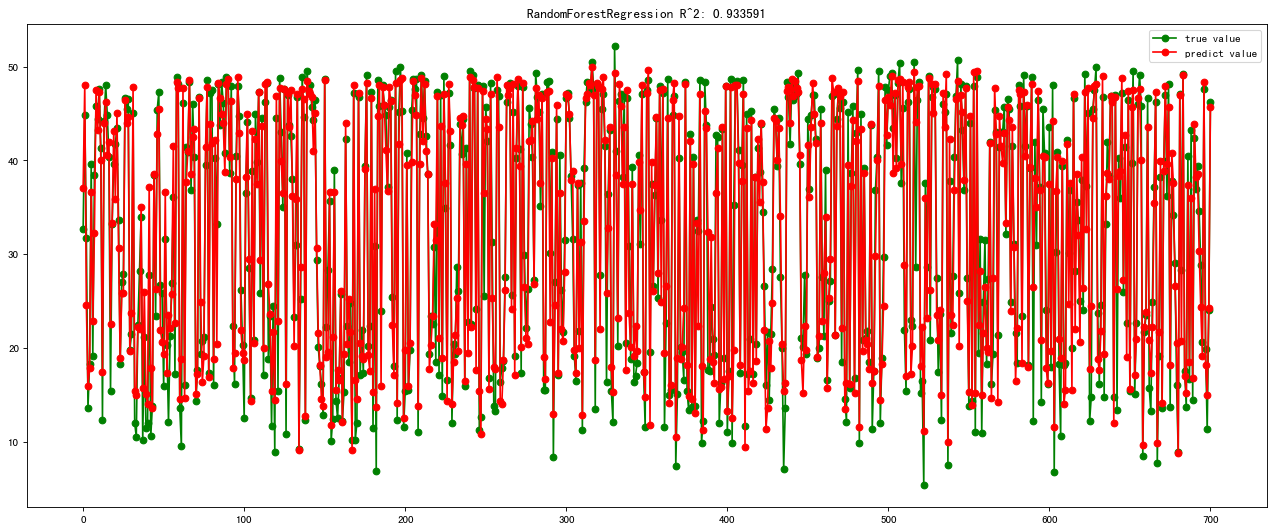

In [17]:
# get the trained model and apply it to data in 'test.csv'
y_pred,trained_model = regression_method(rf_processed)

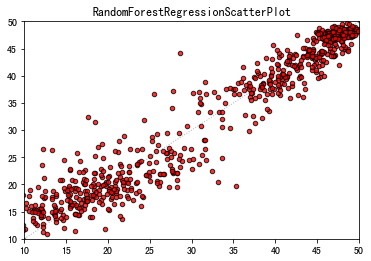

In [18]:
scatter_plot(y_test,y_pred)  #生成散点图

## Part 5. Read test data and get prediction result

In [25]:
data_test = pd.read_csv("test.csv", index_col='id', parse_dates=[1], dayfirst=True)
# data_test['datetime'] = pd.to_datetime(data_test['date'])
data_test['hour'] = pd.to_datetime(data_test['date']).apply(lambda x: x.hour)
data_test['hour'] = data_test['hour']/23
data_test['weekday'] = pd.to_datetime(data_test['date']).apply(lambda x: x.dayofweek)
data_test['weekday'] = data_test['weekday']/6
data_test['month'] = pd.to_datetime(data_test['date']).apply(lambda x:x.month)
data_test['month'] = data_test['month']/12
data_test['day'] = pd.to_datetime(data_test['date']).apply(lambda x:x.day)
data_test['day'] = data_test['day']/30
data_test['time'] = (data_test['date']-min_time)/(max_time-min_time)
data_test.head()

,date,hour,weekday,month,day,time
id,,,,,,
0,2018-01-01 02:00:00,0.086957,0.0,0.083333,0.033333,0.500228
1,2018-01-01 05:00:00,0.217391,0.0,0.083333,0.033333,0.500400
2,2018-01-01 07:00:00,0.304348,0.0,0.083333,0.033333,0.500514
3,2018-01-01 08:00:00,0.347826,0.0,0.083333,0.033333,0.500571
4,2018-01-01 10:00:00,0.434783,0.0,0.083333,0.033333,0.500685


In [26]:
predict_x = data_test[['time','weekday','hour','month','day']]
predict_x.shape

(3504, 5)

In [27]:
y = trained_model.predict(predict_x)

## Part6. Save results in the required form

In [28]:
y = y.reshape(-1,1)

index = np.arange(len(y))
index = index.reshape(-1,1)

df = pd.DataFrame(dict(date=data_test['date'].ravel(), id=index.ravel()))
df.drop(['date'], axis=1, inplace=True)
df = pd.DataFrame(dict(id=df['id'].ravel(), speed=y.ravel()))
df

,id,speed
0,0,48.072983
1,1,47.510731
2,2,34.284310
3,3,31.917430
4,4,35.373165
...,...,...
3499,3499,15.100623
3500,3500,22.170066
3501,3501,42.625738
3502,3502,39.505635


In [29]:
df.to_csv("rf-new.csv",index=False)